# Heart Disease Prediction – EDA, Preprocessing, Training & Saving Model

## 0. Load Dataset

In [8]:

import pandas as pd
url = "https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/heart-disease.csv"

df = pd.read_csv(url)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1. Basic Dataset Information

In [9]:

print("Shape:", df.shape)
df.info()


Shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### 1.1 Nulls and Duplicates

In [10]:

print("Missing values per column:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())


Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Duplicate rows: 1


## 2. Statistical Summary

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


## 3. Correlation Heatmap

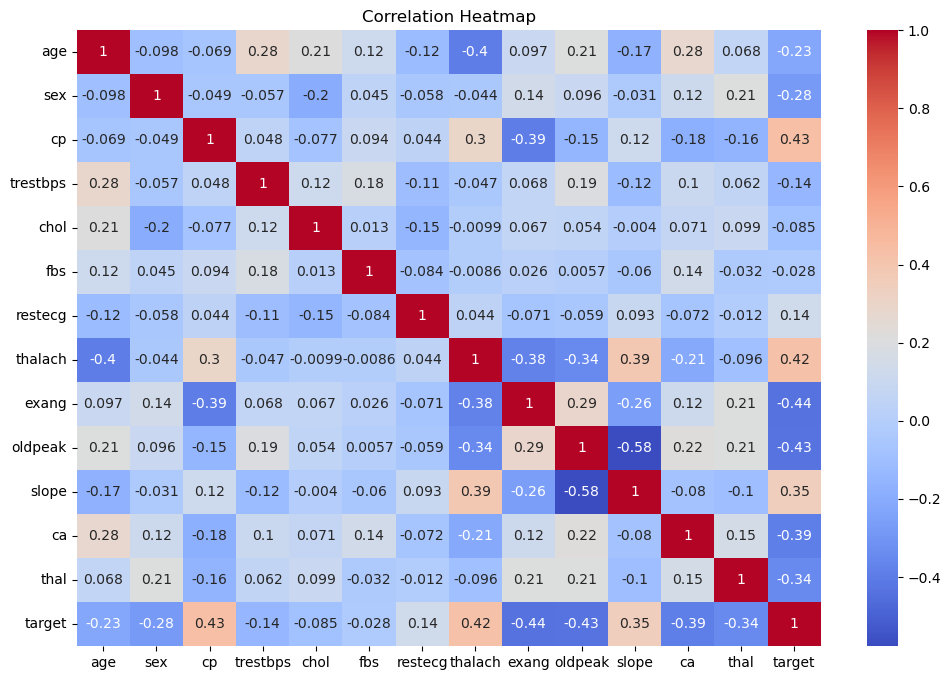

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## 4. Distributions of Numerical Features

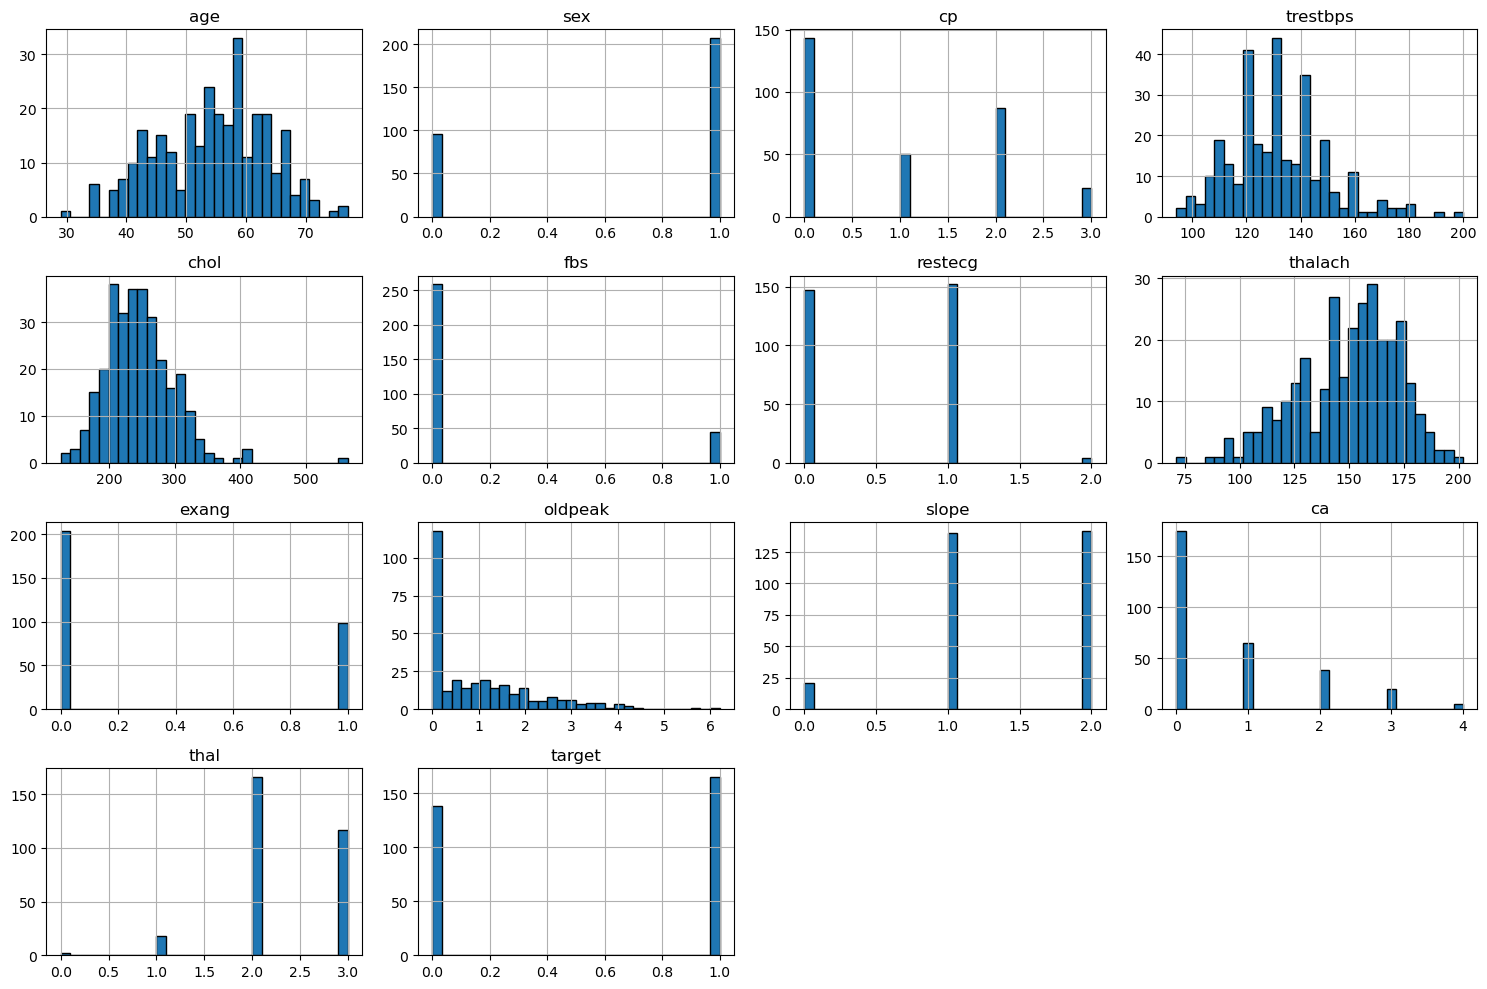

In [13]:

numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=30, figsize=(15,10), edgecolor='black')
plt.tight_layout()
plt.show()


## 5. Preprocessing Pipeline

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
X = df.drop('target', axis=1)
y = df['target']
categorical = ['cp','restecg','slope','thal','ca','sex','fbs','exang']
numeric = [col for col in X.columns if col not in categorical]
numeric_transform = Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('scaler', StandardScaler())])
categorical_transform = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer([('num', numeric_transform, numeric),
                                ('cat', categorical_transform, categorical)])


## 6. Modeling & Evaluation

In [15]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
models = {'LogReg': LogisticRegression(max_iter=1000),
          'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42)}
best_model_name, best_auc, best_pipe = None, 0, None
for name, model in models.items():
    pipe = Pipeline([('preprocess', preprocess), ('clf', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    print(f"\n{name} AUC: {auc:.3f}")
    print(classification_report(y_test, preds))
    if auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_pipe = pipe
print(f"Best model: {best_model_name} (AUC={best_auc:.3f})")



LogReg AUC: 0.865
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


RandomForest AUC: 0.776
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61

Best model: LogReg (AUC=0.865)


## 7. Save Best Model to joblib

In [16]:

import joblib
joblib.dump(best_pipe, 'heart_disease_model.joblib')
print("Model saved as heart_disease_model.joblib")


Model saved as heart_disease_model.joblib
